# Goals of this notebook: 

- Pull orbit of a pair given their subhalo ids
- Work with the group catalogs and the merger trees

 <font color="red"> Note: this notebook will ONLY WORK if you have the catalog and/or merger tree catalog data downloaded. The location of each set of files must be specified.


In [1]:
# import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
# import sys

from harvesting_tools.harvest_paths import SetupPaths
from harvesting_tools.readsubfHDF5_Py3 import subfind_catalog as readCatalog
from harvesting_tools.readtreeHDF5_public import TreeDB as plantTree
from harvesting_tools.merger_trees import TraceMergerTree 
from harvesting_tools.vector_correction import vectorCorrection as vector

In [2]:
# initialize matplotlib params and update
plt.show();
plt.rcParams.update({'font.size':18,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18})


<font color='red'> Make sure to update the below path with the correct path from your own machine.

In [3]:
path_to_harvest = "/xdisk/gbesla/katiechambe/harvest"
paths = SetupPaths(path_to_harvest)

How do we get the orbits and subhalo data for pairs that are not in the pair or orbit catalogs provided? We need to use data from IllustrisTNG. You must start by downloading the necessary group catalogs or merger trees from the [TNG Website](https://www.tng-project.org/data/downloads/TNG100-1/). 

See SETUP/download_TNGdata/ for more information about creating the correct file structure to use this code base! Then once you have the required data listed at the beginning of each section, you can provide the path to the directory where the data is stored to perform analysis. Alternatively, see the TNG website for an excellent explanation of how to download their data. 

# Working with Group Catalogs

The TNG group catalogs (there is one catalog for each snapshot) were developed by the TNG team and contain information about the FoF groups and subhalos that were identified via the SUBFIND algorithm. 

<font color='red'>In order to complete this section, minimum data requirements are:
- group catalog for snapshot 99  [(found here -- you must create a TNG account for data access)](https://www.tng-project.org/api/TNG100-1/files/)
- offset file for snapshot 99 [(found here -- again, must be logged in for data access)](https://www.tng-project.org/api/TNG100-1/files/offsets/)

First, we must specify the path to the TNG (or Illustris) data:

In [4]:
path_to_tng = "/xdisk/gbesla/katiechambe/IllustrisTNG/TNG100-1/"
paths.tng(path_to_tng)

Let's find a MW--LMC-type analog in TNG100 at z=0.
To identify analogs, we need:
- a group mass similar to the Local Group mass (or a little lower)
- a MW-analog as the most massive halo (with halo mass similar to the Milky way)
- an LMC-analog, which has stellar mass ratio 1:10 (for simplicity, we'll use the stellar mass from the simulation)

The relevant keys in the group catalogs that we need are: 
- 'GroupFirstSub' (almost always needed - this is the key for finding the subhalo IDs associated with a FoF group)
- 'Group_M_TopHat200' (the virial mass of the FoF group)
- 'GroupNsubs' (the number of subhalos in the FoF group)
- 'SubhaloGrNr' (also almost always needed - this is the ID of the FoF group the subhalo is a part of)
- 'SubhaloMass' (the mass of each subhalo)
- 'SubhaloMassType' (the mass of each mass component of a subhalo. 0-Gas, 1-DM, 2-N/A, 3-Tracers, 4-Stars & Wind Particles, 5-BHs
  
[More detail on the keys/fields available are here](https://www.tng-project.org/data/docs/specifications/#sec2a) 

In [5]:
keysel_list = ['GroupFirstSub','Group_M_TopHat200', 'GroupNsubs',
               'SubhaloGrNr','SubhaloMass','SubhaloMassType']
# if you do not include a key list, it will load ALL the data by default and 
# take forever/maybe crash your job, so better to specify

In [6]:
# using the subfind_catalog method from the readsubfHDF5_Py3 script
catalog = readCatalog( basedir=paths.tng_base, snapnum=99, keysel=keysel_list)

In [7]:
# note! all of the below values are in SIMULATION units (i.e. Msun/h) 
redshift = catalog.redshift
group_firstsub = catalog.GroupFirstSub
group_nsubs = catalog.GroupNsubs
group_mass = catalog.Group_M_TopHat200
subhalo_groupnum = catalog.SubhaloGrNr
subhalo_mass = catalog.SubhaloMass
subhalo_masstype = catalog.SubhaloMassType 

You can think of the Group data as it's own data table, and the Subhalo data as a separate data table. They are different lengths, so you cannot just find the 10th element of each list and associate them.

### Looking for LG-mass analog FoF groups

We'll start by looking for a Group with mass between 1-4e12 Msun, which is similar to the Local Group mass. First, convert group masses to physical units, then create masks to isolate only groups that pass our group mass criterion.

In [8]:
# little_h = 0.704 # for Illustris
little_h = 0.6774 # for TNG
group_mass_phys = group_mass/little_h

In [9]:
group_mass_mask = (group_mass_phys > 100) & (group_mass_phys < 400)

print(f"Total number of groups at z=0: ",np.count_nonzero(group_mass_phys))
print(f"Number of groups within our desired mass range: ",np.count_nonzero(group_mass_mask))

Total number of groups at z=0:  3428717
Number of groups within our desired mass range:  1644


In [10]:
# the IDs (or indices) of the local group mass analogs in the group catalog
lganalog_ids = np.where(group_mass_mask)
lganalog_ids[0:10]

(array([ 351,  389,  399, ..., 2724, 2768, 2777]),)

### Exploring subhalo information
We're only going to consider the groups identified above and search for subhalos with the appropriate stellar mass ratios.

In [11]:
# print out information about the first group, groupnum = 351
print("Most massive subhalo ID: ", group_firstsub[351])
print("Group mass: ", group_mass_phys[351])
print("Number of subhalos in the group: ", group_nsubs[351])

Most massive subhalo ID:  367929
Group mass:  290.0397788116212
Number of subhalos in the group:  241


The subhalo ID of the most massive DM subhalo in this group is 367929. Let's double check this by printing the subhalo ID of every subhalo with groupnum = 351 (there should be 241 of them)
    

In [12]:
lganalog_subhaloids = np.where(subhalo_groupnum == 351)[0]
print("Largest subhalo is: ",lganalog_subhaloids[0])
print("Number of subhalos with this groupnum: ",len(lganalog_subhaloids))

Largest subhalo is:  367929
Number of subhalos with this groupnum:  241


yay! 

now, let's find the stellar mass of the most massive subhalo (subhalo #367929)

In [13]:
subid1 = 367929
submass1 = subhalo_mass[subid1]/little_h
stellmass1 = subhalo_masstype[subid1][4]/little_h

print(f"Subhalo DM mass is {submass1:0.2f}*1e10 Msun")
print(f"Subhalo stellar mass is {stellmass1:0.2f}*1e10 Msun")

Subhalo DM mass is 286.84*1e10 Msun
Subhalo stellar mass is 5.26*1e10 Msun


Let's find the stellar mass of the second most massive subhalo in the group! Since this group has more than 1 subhalos (given by group_nsubs above), we can just add 1 to the first subhalo id to get the second most massive halo by dark matter mass in the group. 

In [14]:
subid2 = subid1 + 1
submass2 = subhalo_mass[subid2]/little_h
stellmass2 = subhalo_masstype[subid2][4]/little_h

print(f"Subhalo DM mass of the secondary is {submass2:0.2f}*1e10 Msun")
print(f"Subhalo stellar mass of the secondary is {stellmass2:0.2f}*1e10 Msun")

print(f"This gives a stellar mass ratio of: {stellmass2/stellmass1:0.2f}")

Subhalo DM mass of the secondary is 95.65*1e10 Msun
Subhalo stellar mass of the secondary is 4.42*1e10 Msun
This gives a stellar mass ratio of: 0.84


This mass ratio is way too high to be a MW-LMC-mass analog, since we want a stellar mass ratio of ~1:10.
We could then check every group that passed the group mass criteria to find groups that might pass the this mass ratio criterion. But, I'm not going to do that. Instead, lets make a plot of some relevant data about the subhalos in this group

In [15]:
# plot the dark matter mass vs. the stellar mass of each subhalo in the group to see the distribution
all_stellar_masses = subhalo_masstype[lganalog_subhaloids][:,4] / little_h
all_DM_masses = subhalo_mass[lganalog_subhaloids] / little_h

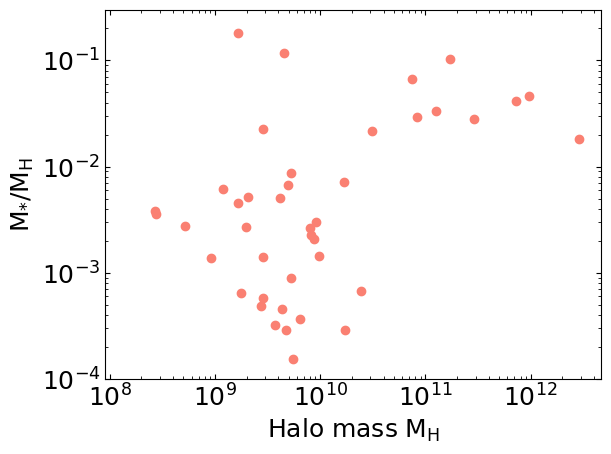

In [16]:
plt.scatter(all_DM_masses * 1e10, all_stellar_masses/all_DM_masses,color='salmon')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4,3e-1)
plt.ylabel(r"$\rm M_{*}/M_{H}$")
plt.xlabel(r"Halo mass $\rm M_{H}$")
plt.show()

For fun, we can overplot the SMHM relationship from Moster 2013+

In [17]:
from harvesting_tools.abundance_matching import AbundanceMatching

halo_masses = np.logspace(8,13)
am_stellar_masses = AbundanceMatching(maxmass=halo_masses, 
                                    redshift=0,
                                    samples=1).stellar_mass(med=True)

SMHMratio = am_stellar_masses/halo_masses

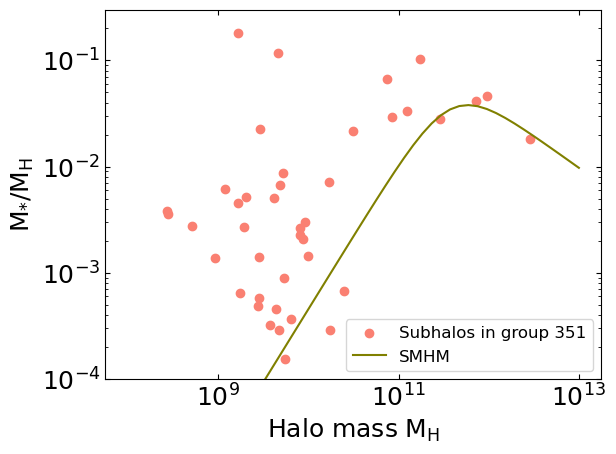

In [18]:
plt.scatter(all_DM_masses * 1e10, all_stellar_masses/all_DM_masses, label="Subhalos in group 351", color='salmon')
plt.plot(halo_masses, SMHMratio, label="SMHM", color='olive')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4,3e-1)
plt.ylabel(r"$\rm M_{*}/M_{H}$")
plt.xlabel(r"Halo mass $\rm M_{H}$")
plt.legend(fontsize=12)
plt.show()

# Working with Merger Trees

The merger trees follow tracer particles between snapshots of the TNG simulation, which allow us to track a specific subhalo or subhalo pair between snapshots. Here, we'll pull out the mass history of a pair identified at z=1 (high mass major pair from the pair catalog), and then pull out it's orbit. 

*This section can be run without needing to run the previous section*

<font color='red'>In order to run this section, minimum data requirements are:
- merger tree files (all) [(found here -- you must create a TNG account for data access)](https://www.tng-project.org/api/TNG100-1/files/sublink/)


In [19]:
path_to_tng = "/xdisk/gbesla/katiechambe/IllustrisTNG/TNG100-1/"
paths.tng(path_to_tng)

In [20]:
# these subhalo ids come from a pair at z=1 and the high mass major pair sample
subid1 = 155680
subid2 = 155681

In [21]:
# define tree (point to tree files)
tree = plantTree(paths.tng_trees)

In [22]:
# a subhalo's merger tree consists of two components: past and present
pastbranch = tree.get_main_branch(snapnum=50, subfind_id=subid1)
futurebranch = tree.get_future_branch(snapnum=50, subfind_id=subid1)

In [23]:

past_snaps = pastbranch.SnapNum
future_snaps = futurebranch.SnapNum

In [24]:
# get arrays of the subhalo mass on past and future branches of the merger trees and put in physical units 
little_h = 0.6774 # for TNG
past_mass = pastbranch.SubhaloMass / little_h
future_mass = futurebranch.SubhaloMass / little_h

# corresponding snapshot numbers
past_snaps = pastbranch.SnapNum
future_snaps = futurebranch.SnapNum

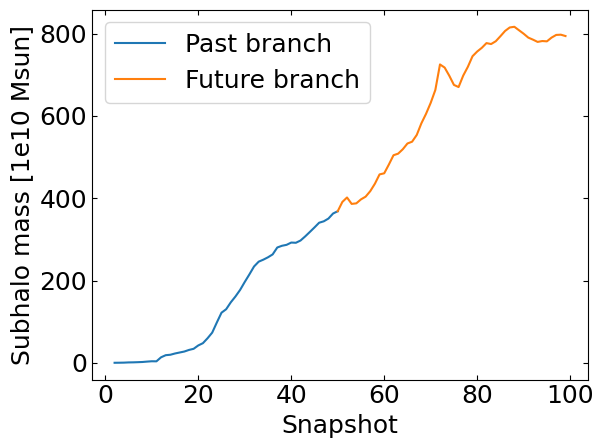

In [25]:
plt.plot(past_snaps, past_mass, label="Past branch")
plt.plot(future_snaps, future_mass, label="Future branch")
plt.xlabel("Snapshot")
plt.ylabel("Subhalo mass [1e10 Msun]")
plt.legend()
plt.show()

In [26]:
# Alternatively, use TraceMergerTree and the mergedbranch method to pull the entire branch at the same time
alt = TraceMergerTree(treepath=paths.tng_trees,snapshot=50, subfindID=subid1) 

full_snaps = alt.fullbranch["SnapNum"]
full_mass = alt.fullbranch["SubhaloMass"]

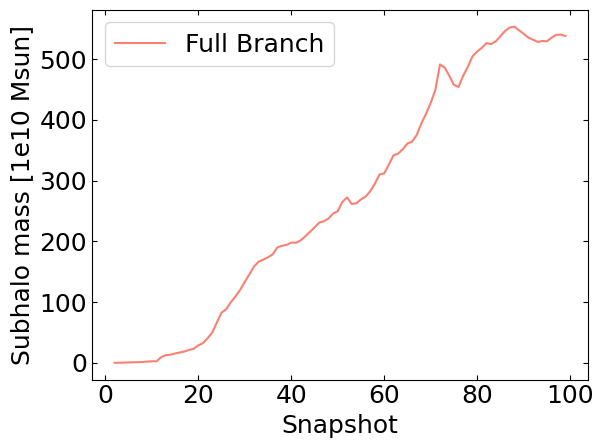

In [27]:
plt.plot(full_snaps, full_mass,label='Full Branch',color='salmon')
plt.xlabel("Snapshot")
plt.ylabel("Subhalo mass [1e10 Msun]")
plt.legend()
plt.show()

### Pull orbit data

In [28]:
# get merger trees for subhalo pair (pair from high mass major pair sample at z=1)
subid1 = 155680
subid2 = 155681

sub1_tree = TraceMergerTree(treepath=paths.tng_trees, snapshot=50, subfindID=subid1)
sub2_tree = TraceMergerTree(treepath=paths.tng_trees, snapshot=50, subfindID=subid2)

In [29]:
# pull out the full branches (past & future)
primary_branch = sub1_tree.fullbranch
secondary_branch = sub2_tree.fullbranch

In [30]:
# initialize separation array
seps = np.zeros(100)
seps.fill(np.NaN)

In [31]:
# for the next part where we calculate the separation between the subhalos at each snapshot,
# we will need the scale of the simulation at each snapshot to convert from simulation units (comoving)
# to physical units
f = h5py.File(f"{paths.path_data}misc/snapshot_data.hdf5","r")
convert = {}
for key,val in f.items():
    convert[key] = np.array(val)
f.close()

In [32]:
# for each snapshot in the simulation 0-99, check if the primary and secondary both exist:
for snap in np.arange(0,100):
    if (snap in primary_branch['SnapNum']) and (snap in secondary_branch['SnapNum']):
        # location of snapshot in trees
        loc1 = np.where(primary_branch['SnapNum'] == snap)[0]
        loc2 = np.where(secondary_branch['SnapNum'] == snap)[0]

        # ----------------------------------------------------
        # calculate separation between both halos
        subpos1 = primary_branch['SubhaloPos'][loc1] # in comoving units
        subpos2 = secondary_branch['SubhaloPos'][loc2] # in comoving units

        corrected_diffvector = vector(subpos1,subpos2,75000) # to account for the edges of the simulation box
        comoving_dist = np.linalg.norm(corrected_diffvector) # calculating the norm of the difference vector

        # need scale of simulation at each redshift to compute phys distance
        scale = convert["Scale"][snap]
        phys_dist = comoving_dist*(scale)/little_h

        seps[snap] = phys_dist # fill in separation array with the calculated separation. if none, np.nan will be in place.
        


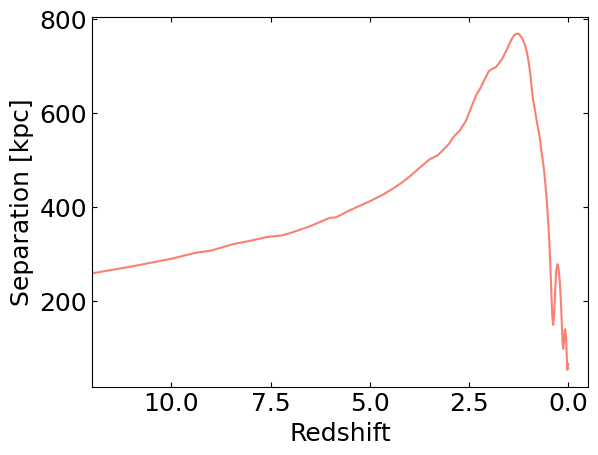

In [33]:
# plot separation as a function of lookback time
redshifts = convert['Redshift']

plt.plot(redshifts, seps, color='salmon')
plt.xlim(12,-.5)
plt.xlabel("Redshift")
plt.ylabel("Separation [kpc]")
plt.show()

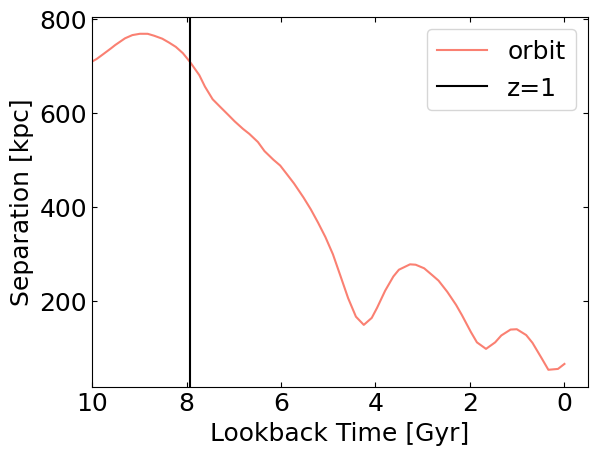

In [34]:
# plot separation as a function of lookback time
lookback = convert['Lookback Time']
lbt_at_z1 = convert['Lookback Time'][50]

plt.plot(lookback, seps, color='salmon', label="orbit")
plt.xlim(10,-.5)
plt.xlabel("Lookback Time [Gyr]")
plt.ylabel("Separation [kpc]")
plt.axvline(lbt_at_z1, color='black', label="z=1")
plt.legend()
plt.show()

<font color='grey'> *author:* Dr. Katie Chamberlain  -- May 2024